# Combine CDR3 clusters 

In [1]:
import pickle
import sys
import time

import logomaker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from mir.distances import graph

sys.path.append('../')

new_rc_params = {'text.usetex': False, 'svg.fonttype': 'none'}
plt.rcParams.update(new_rc_params)

Import TCGA data with meta.

In [2]:
tcga = pd.read_csv("/projects/tcr_bcr_rnaseq/tcga_airr_compiled.txt.gz", sep="\t")
# add project id aka cancer type
meta = pd.read_csv("~/tcga_metadata.tsv", sep="\t")
meta = meta.drop(
    columns=["file_name", "file_path", "sample_id", "normal", "cancer", "PASS"]
)  # удалим колонки, которые задублированны
meta = meta.drop_duplicates()  # и теперь дублирующиеся строки
tcga_meta = pd.merge(tcga, meta, left_on="sample", right_on="submitter_id")
tcga_meta.head(2)

,file.name,sample,locus,v_call,j_call,c_call,junction,junction_aa,duplicate_count,project_id,...,tissue_or_organ_of_origin,days_to_birth,progression_or_recurrence,prior_malignancy,site_of_resection_or_biopsy,days_to_last_follow_up,therapeutic_agents,treatment_intent_type,treatment_or_therapy,priority
0,/projects/tcga/data/TCGA-02-0047.1.clonotypes....,TCGA-02-0047,IGH,IGHV4-59,IGHJ4,IGHG1,TGTGCGAGAGGCAGCTGGTACTTTGACTACTGG,CARGSWYFDYW,5,TCGA-GBM,...,C71.9,-28759.0,not reported,not reported,C71.9,448.0,--,--,--,0
1,/projects/tcga/data/TCGA-02-0047.1.clonotypes....,TCGA-02-0047,IGH,IGHV1-69,IGHJ3,IGHG1,TGTGCGAGAGGGAGCTGGAGGATGGAGCAAGTCCCCGAATTTAATG...,CARGSWRMEQVPEFNDFNMW,2,TCGA-GBM,...,C71.9,-28759.0,not reported,not reported,C71.9,448.0,--,--,--,0


# Sampling cancers to balance batch sizes

❗ Sampling should be based on the **number of repertoires per cancer**, not on the count of unique patients (i.e. Samples).

Note: Cancers with low sample counts might still have sufficient repertoire numbers.

**Implementation details:**
1. First select the **TRA locus** 
2. Perform sampling only from TRA repertoires (not from all available data)

In [3]:
SET_LOCUS = "TRA"
tcga_sampled = tcga_meta.copy()
tcga_sampled = tcga_sampled[tcga_sampled.locus == SET_LOCUS]
tcga_sampled.rename(columns={"project_id": "TCGA_project"}, inplace=True)
print("All cancers:", tcga_sampled.shape)

All cancers: (306824, 39)


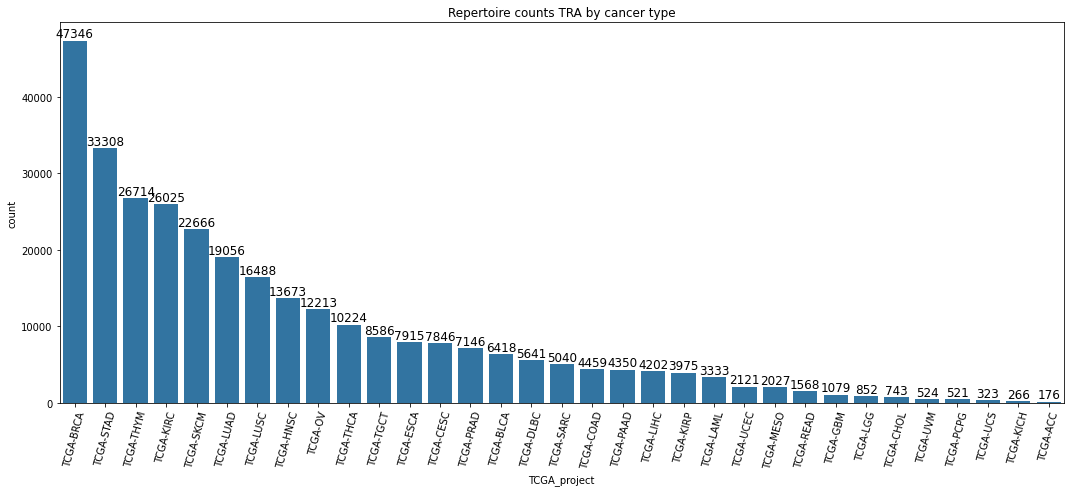

In [4]:
cans = tcga_sampled.TCGA_project.value_counts()
plt.figure(figsize=(18, 7))
ax = sns.barplot(cans)
ax.bar_label(ax.containers[0], fontsize=12)
plt.xticks(rotation=75)
plt.title(f"Repertoire counts {SET_LOCUS} by cancer type")
plt.show()

**Filtering:**
- Minimum 1000 repertoires per cancer type
- Exclude cancers failing this threshold

In [5]:
low_cancers = [
    "TCGA-ACC",
    "TCGA-KICH",
    "TCGA-UCS",
    "TCGA-PCPG",
    "TCGA-UVM",
    "TCGA-CHOL",
    "TCGA-LGG",
]
tcga_sampled = tcga_sampled[~tcga_sampled["TCGA_project"].isin(low_cancers)]
print(f"Selected cancers in {SET_LOCUS} locus: {tcga_sampled.shape}")

Selected cancers in TRA locus: (303419, 39)


In [6]:
# sampling
tcga_sampled = tcga_sampled.groupby("TCGA_project", group_keys=False).sample(
    n=1000, random_state=42
)
tcga_sampled.rename(columns={"junction_aa": "cdr3aa"}, inplace=True)
tcga_sampled.shape

(26000, 39)

# Find clusters

In [5]:
def generate_masks(seq: str):
    """
    Generates mask on sequence with one replace position
    """

    masks = set()
    for i in range(len(seq)):
        clone_to_search = seq[:i] + "X" + seq[i + 1 :]
        masks.add(clone_to_search)
    return masks


def process_one_lenght(masks_series):
    """
    masks_series.index: cdr3's of a single length
    masks_series.values: masks on every sequence
    """

    res_list = []
    print(f"processing lenghts {len(masks_series.index[0])} started")
    while len(masks_series) > 1:
        cur_clust = set()
        cur_masks = set()

        cur_clust.add(masks_series.index[0])
        cur_masks = cur_masks.union(masks_series.iloc[0])

        for cdr3, masks in masks_series.items():

            if cur_masks.intersection(masks):
                cur_masks = cur_masks.union(masks)
                cur_clust.add(cdr3)

        masks_series.drop(list(cur_clust), inplace=True)
        res_list.append(cur_clust)
    print(f"processing lenghts {len(cdr3)} completed")
    return res_list


from multiprocessing import Pool

# top_all = top_all.loc[top_all.cdr3aa.drop_duplicates().index]


def process_all_lenghts(top_all, num_cores=None):

    len_dist = top_all.cdr3aa.apply(len).value_counts()

    lenghts_dfs = []
    for i in len_dist[len_dist > 10].index:
        top_all_i = top_all[top_all.cdr3aa.apply(lambda x: len(x) == i)]

        top_all_i_masks = top_all_i.cdr3aa.apply(lambda x: generate_masks(x))
        top_all_i_masks.index = top_all_i.cdr3aa
        lenghts_dfs.append(top_all_i_masks)

    print("Start processing")
    # with Pool(len(lenghts_dfs)) as p:
    # res_list = list(p.map(process_one_lenght, lenghts_dfs))

    with Pool(processes=min(num_cores, len(lenghts_dfs))) as p:
        res_list = list(p.map(process_one_lenght, lenghts_dfs))

    return sum(res_list, [])

In [23]:
%%time

tcga_sampled.rename(columns={"junction_aa": "cdr3aa"}, inplace=True)
tcga_sampled = tcga_sampled[
    tcga_sampled.cdr3aa.apply(lambda x: "*" not in x and "_" not in x)
]

res = process_all_lenghts(tcga_sampled, num_cores=31)
with open("clustering_result_TRA_sampled.pkl", "wb") as f:
    pickle.dump(res, f)

Start processing
processing lenghts 14 started
processing lenghts 13 started
processing lenghts 12 started
processing lenghts 11 started
processing lenghts 17 startedprocessing lenghts 15 started
processing lenghts 16 startedprocessing lenghts 10 started
processing lenghts 18 started
processing lenghts 9 started


processing lenghts 9 completed
processing lenghts 18 completed
processing lenghts 10 completed
processing lenghts 17 completed
processing lenghts 11 completed
processing lenghts 16 completed
processing lenghts 12 completed
processing lenghts 15 completed
processing lenghts 13 completed
processing lenghts 14 completed
CPU times: user 96.2 ms, sys: 825 ms, total: 922 ms
Wall time: 1.34 s


# Analyze clusters

In [7]:
with open("clustering_results/sampled_clustering_result_TRA.pkl", "rb") as p:
    res = pickle.load(p)

In [8]:
res = pd.Series(res)
exploded_series = res.explode()
res_exploded = pd.DataFrame(exploded_series).reset_index()
res_exploded.rename(columns={0: "cdr3", "index": "cluster_id"}, inplace=True)
res_exploded.set_index("cdr3", inplace=True)

cdr3_set = set(res_exploded.index)
tcga_sampled.rename(columns={"junction_aa": "cdr3aa"}, inplace=True)
tcga_sampled = tcga_sampled.loc[tcga_sampled.cdr3aa.apply(lambda x: x in cdr3_set)]

In [9]:
to_plot_conc = pd.concat(
    [
        res_exploded.loc[list(tcga_sampled.cdr3aa)].reset_index(),
        tcga_sampled.reset_index(drop=True),
    ],
    axis=1,
)
# get cluster size
clusters_size_dict = to_plot_conc.cluster_id.value_counts().to_dict()
to_plot_conc.insert(
    0, "cluster_size", to_plot_conc.cluster_id.apply(lambda x: clusters_size_dict[x])
)
to_plot_conc.head(2)

,cluster_size,cdr3,cluster_id,file.name,sample,locus,v_call,j_call,c_call,junction,...,tissue_or_organ_of_origin,days_to_birth,progression_or_recurrence,prior_malignancy,site_of_resection_or_biopsy,days_to_last_follow_up,therapeutic_agents,treatment_intent_type,treatment_or_therapy,priority
0,1,CNAGAAGNMLTF,5802,/projects/tcga/data/TCGA-GC-A3I6.1.clonotypes....,TCGA-GC-A3I6,TRA,TRAV26-2,TRAJ39,TRAC,TGCAACGCGGGGGCTGCAGGCAACATGCTCACCTTT,...,C67.9,-16504.0,not reported,not reported,C67.9,68.0,--,--,--,2
1,1,CAVVRASGTYKYIF,0,/projects/tcga/data/TCGA-G2-A2EC.1.clonotypes....,TCGA-G2-A2EC,TRA,TRAV36DV7,TRAJ40,TRAC,TGTGCTGTGGTAAGGGCCTCAGGAACCTACAAATACATCTTT,...,C67.9,-21215.0,not reported,not reported,C67.9,679.0,--,--,--,2


In [10]:
dummies_conc = pd.concat(
    [
        to_plot_conc.drop("TCGA_project", axis=1),
        pd.get_dummies(to_plot_conc.TCGA_project),
    ],
    axis=1,
)
dummies_conc = dummies_conc[dummies_conc.cluster_size >= 2]
dummies_conc.head(2)

,cluster_size,cdr3,cluster_id,file.name,sample,locus,v_call,j_call,c_call,junction,...,TCGA-PAAD,TCGA-PRAD,TCGA-READ,TCGA-SARC,TCGA-SKCM,TCGA-STAD,TCGA-TGCT,TCGA-THCA,TCGA-THYM,TCGA-UCEC
3,30,CAVPGGGADGLTF,3220,/projects/tcga/data/TCGA-ZF-AA5H.1.clonotypes....,TCGA-ZF-AA5H,TRA,TRAV2,TRAJ45,TRAC,TGTGCTGTGCCAGGAGGAGGTGCTGACGGACTCACCTTT,...,False,False,False,False,False,False,False,False,False,False
5,24,CAVSALTGGGNKLTF,7362,/projects/tcga/data/TCGA-E7-A97P.1.clonotypes....,TCGA-E7-A97P,TRA,TRAV12-2,TRAJ10,TRAC,TGTGCCGTGAGTGCACTCACGGGAGGAGGAAACAAACTCACCTTT,...,False,False,False,False,False,False,False,False,False,False


Lets observe some clusters

In [11]:
to_plot_conc.cluster_id.value_counts().reset_index()

,cluster_id,count
0,5807,193
1,3225,121
2,5823,94
3,9794,92
4,5913,91
...,...,...
13443,1371,1
13444,8289,1
13445,6506,1
13446,12126,1


In [19]:
a = to_plot_conc.cluster_id.value_counts().reset_index()
len(a[a["count"] > 10])

206

In [17]:
cluster_id_selected = 5807
print(to_plot_conc[to_plot_conc.cluster_id == cluster_id_selected].cdr3.nunique())
to_plot_conc[to_plot_conc.cluster_id == cluster_id_selected].cdr3.unique()

58


array(['CAVSDSNYQLIW', 'CAFSDSNYQLIW', 'CAVMDSNYQLIW', 'CAVTDSNYQLIW',
       'CAVKDSNYQLIW', 'CAVVDSNYQLIW', 'CALTDSNYQLIW', 'CACMDSNYQLIW',
       'CVVTDSNYQLIW', 'CAAMDSNYQLIW', 'CAPMDSNYQLIW', 'CAVLDSNYQLIW',
       'CALGDSNYQLIW', 'CAVRDSNYQLIW', 'CAALDSNYQLIW', 'CAAPDSNYQLIW',
       'CAVRNSNYQLIW', 'CVAMDSNYQLIW', 'CAVMDSNYQLIQ', 'CVLMDSNYQLIW',
       'CAVEDSNYQLIW', 'CAGMDSNYQLIW', 'CAVINSNYQLIW', 'CAVPDSNYQLIW',
       'CATMDSNYQLIW', 'CAPEDSNYQLIW', 'CANMDSNYQLIW', 'CAARDSNYQLIW',
       'CAMKDSNYQLIW', 'CALSDSNYQLIW', 'CASMDSNYQLIW', 'CAGLDSNYQLIW',
       'CASLDSNYQLIW', 'CAGQDSNYQLIW', 'CAVLSSNYQLIW', 'CVVTSSNYQLIW',
       'CAGPDSNYQLIW', 'CALRNSNYQLIW', 'CAIMDSNYQLIW', 'CALSDSNYQLIG',
       'CAEGDSNYQLIW', 'CADMDSNYQLIW', 'CAVFDSNYQLIW', 'CAVRGSNYQLIW',
       'CAVRDRNYQLIW', 'CAVFHSNYQLIW', 'CAMSDSNYQLIW', 'CAVQDSNYQLIW',
       'CAVKESNYQLIW', 'CACSDSNYQLIW', 'CAVGDSNYQLIW', 'CAFTDSNYQLIW',
       'CIVRDSNYQLIW', 'CAGVDSNYQLIW', 'CALKNSNYQLIW', 'CAVENSNYQLIW',
      

In [18]:
print("N clusters:", to_plot_conc.cluster_id.value_counts().sum())

N clusters: 23596


Make logo on selected cluster

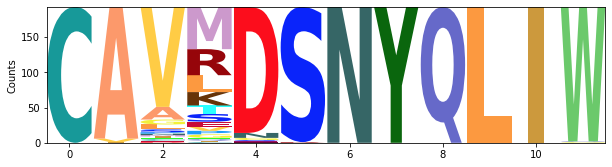

In [19]:
cdr3s = to_plot_conc[to_plot_conc.cluster_id == cluster_id_selected].cdr3
mat_df = logomaker.alignment_to_matrix(cdr3s)
logomaker.Logo(mat_df, color_scheme="skylign_protein", ax=None)
plt.ylabel("Counts")
plt.show()

# Clusters analysis: TRA clusters

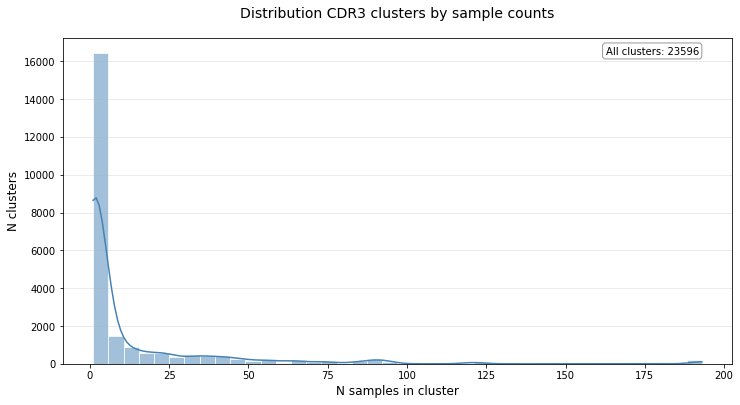

In [13]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(
    to_plot_conc.cluster_size,
    bins=40,
    color="steelblue",
    edgecolor="white",
    linewidth=0.7,
    kde=True,
)
plt.title("Distribution CDR3 clusters by sample counts", fontsize=14, pad=20)
plt.xlabel("N samples in cluster", fontsize=12)
plt.ylabel("N clusters", fontsize=12)
plt.grid(axis="y", alpha=0.3)
# plt.ylim(0, 2000)
total_clusters = len(to_plot_conc)
plt.annotate(
    f"All clusters: {total_clusters}",
    xy=(0.95, 0.95),
    xycoords="axes fraction",
    ha="right",
    bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8),
)
plt.show()

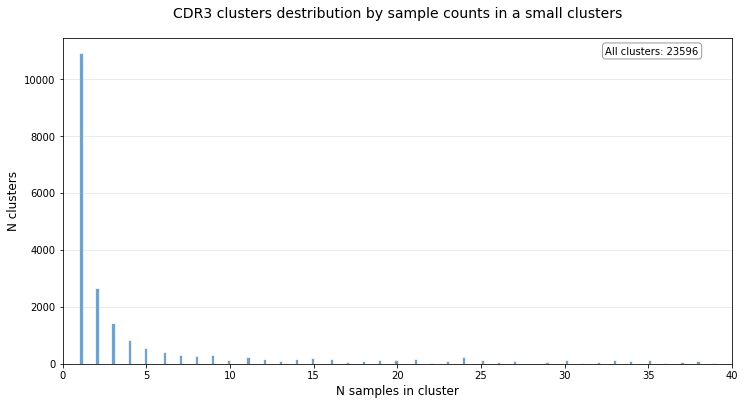

In [14]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(
    to_plot_conc.cluster_size,
    bins=1000,
    color="steelblue",
    edgecolor="white",
    linewidth=0.7,
)
plt.title(
    "CDR3 clusters destribution by sample counts in a small clusters",
    fontsize=14,
    pad=20,
)
plt.xlabel("N samples in cluster", fontsize=12)
plt.ylabel("N clusters", fontsize=12)
plt.grid(axis="y", alpha=0.3)
# plt.ylim(0, 40000)
plt.xlim(0, 40)
total_clusters = len(to_plot_conc)
plt.annotate(
    f"All clusters: {total_clusters}",
    xy=(0.95, 0.95),
    xycoords="axes fraction",
    ha="right",
    bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8),
)
plt.show()

**Observed patterns:**
- Multiple small clusters detected
- Notable peaks present in the distribution plot

In [15]:
max_id = to_plot_conc.cluster_size.max()
max_id

193

In [16]:
top_cluster = to_plot_conc[to_plot_conc["cluster_size"] == max_id]
top_cluster

,cluster_size,cdr3,cluster_id,file.name,sample,locus,v_call,j_call,c_call,junction,...,tissue_or_organ_of_origin,days_to_birth,progression_or_recurrence,prior_malignancy,site_of_resection_or_biopsy,days_to_last_follow_up,therapeutic_agents,treatment_intent_type,treatment_or_therapy,priority
26,193,CAVSDSNYQLIW,5807,/projects/tcga/data/TCGA-BL-A13J.2.clonotypes....,TCGA-BL-A13J,TRA,TRAV8-6,TRAJ33,NaN,TGTGCTGTGAGTGATAGCAACTATCAGTTAATCTGG,...,C67.4,-23927.0,not reported,not reported,C67.4,--,--,--,--,2
700,193,CAFSDSNYQLIW,5807,/projects/tcga/data/TCGA-FD-A6TB.1.clonotypes....,TCGA-FD-A6TB,TRA,TRAV38-2DV8,TRAJ33,TRAC,TGTGCTTTTTCGGATAGCAACTATCAGTTAATCTGG,...,C67.2,-30185.0,not reported,not reported,C67.2,572.0,--,--,--,2
980,193,CAVMDSNYQLIW,5807,/projects/tcga/data/TCGA-AC-A6IV.1.clonotypes....,TCGA-AC-A6IV,TRA,TRAV12-2,TRAJ33,NaN,TGTGCCGTCATGGATAGCAACTATCAGTTAATCTGG,...,C50.9,-17521.0,not reported,not reported,C50.9,568.0,--,--,--,4
1630,193,CAVTDSNYQLIW,5807,/projects/tcga/data/TCGA-LL-A5YP.1.clonotypes....,TCGA-LL-A5YP,TRA,TRAV1-2,TRAJ33,TRAC,TGTGCTGTGACGGATAGCAACTATCAGTTAATCTGG,...,C50.9,-18041.0,not reported,not reported,C50.9,450.0,--,--,--,4
1684,193,CAVKDSNYQLIW,5807,/projects/tcga/data/TCGA-BH-A0B7.1.clonotypes....,TCGA-BH-A0B7,TRA,TRAV12-2,TRAJ33,NaN,TGTGCCGTGAAAGATAGCAACTATCAGTTAATCTGG,...,C50.9,-15593.0,not reported,not reported,C50.9,2559.0,--,--,--,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22373,193,CAVRNSNYQLIW,5807,/projects/tcga/data/TCGA-XU-AAXV.1.clonotypes....,TCGA-XU-AAXV,TRA,TRAV21,TRAJ33,TRAC,TGTGCTGTGAGAAATAGCAACTATCAGTTAATCTGG,...,C37.9,-16582.0,not reported,not reported,C37.9,4070.0,--,--,--,4
22395,193,CAVCGSNYQLIW,5807,/projects/tcga/data/TCGA-YT-A95H.1.clonotypes....,TCGA-YT-A95H,TRA,TRAV3,TRAJ33,NaN,TGTGCTGTGTGCGGGAGCAACTATCAGTTAATCTGG,...,C38.1,-25376.0,not reported,not reported,C38.1,711.0,--,--,--,4
22753,193,CAVTDSNYQLIW,5807,/projects/tcga/data/TCGA-E6-A2P8.1.clonotypes....,TCGA-E6-A2P8,TRA,TRAV2,TRAJ33,TRAC,TGTGCTGTGACGGATAGCAACTATCAGTTAATCTGG,...,C54.1,-19448.0,not reported,not reported,C54.1,--,--,--,--,4
22876,193,CAVLDSNYQLIW,5807,/projects/tcga/data/TCGA-SJ-A6ZI.1.clonotypes....,TCGA-SJ-A6ZI,TRA,TRAV1-2,TRAJ33,TRAC,TGTGCTGTTTTGGATAGCAACTATCAGTTAATCTGG,...,C54.1,-23653.0,not reported,not reported,C54.1,631.0,--,--,--,4


/scratch/ipykernel_2431954/1725301933.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


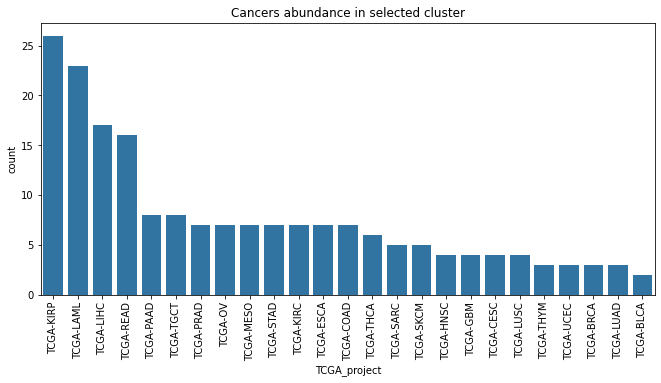

In [18]:
plt.figure(figsize=(11, 5))
g = sns.barplot(top_cluster.TCGA_project.value_counts())
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Cancers abundance in selected cluster")
g
plt.show()

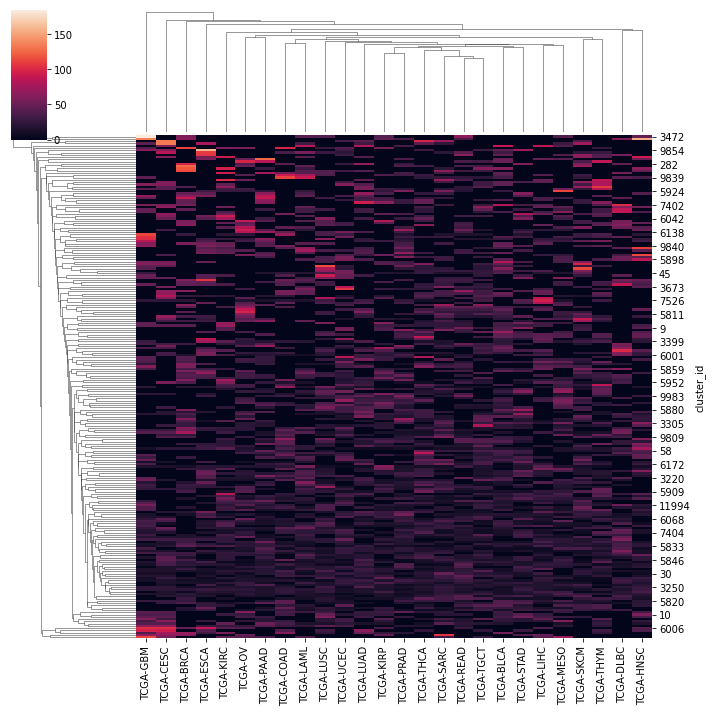

In [19]:
clusters_size_dict = to_plot_conc.cluster_id.value_counts().to_dict()

# to_plot_conc.insert(0, 'cluster_size', to_plot_conc.cluster_id.apply(lambda x: clusters_size_dict[x]))

##################################
## INSERT TCGA PROJECT TO TABLE ##
##################################


dummies_conc = pd.concat(
    [
        to_plot_conc.drop("TCGA_project", axis=1),
        pd.get_dummies(to_plot_conc.TCGA_project),
    ],
    axis=1,
)
dummies_conc = dummies_conc[dummies_conc.cluster_size >= 10]

# add pats
pats = pd.get_dummies(to_plot_conc.TCGA_project).columns.tolist()


cluster_counts = (
    dummies_conc[["cluster_id"] + pats]
    .groupby("cluster_id")
    .apply(sum)
    .drop("cluster_id", axis=1)
)
cluster_counts.insert(0, "total_count", cluster_counts.sum(axis=1))

cluster_freqs = cluster_counts.apply(lambda x: x / cluster_counts.total_count).drop(
    "total_count", axis=1
)

cluster_freqs_advanced = (
    cluster_freqs * 10**5 / cluster_counts[cluster_freqs.columns].sum()
)
sns.clustermap(cluster_freqs_advanced)

In [20]:
cluster_freqs_advanced_log = cluster_freqs_advanced.applymap(lambda x: np.log2(x + 1))
# cluster_freqs_advanced_log

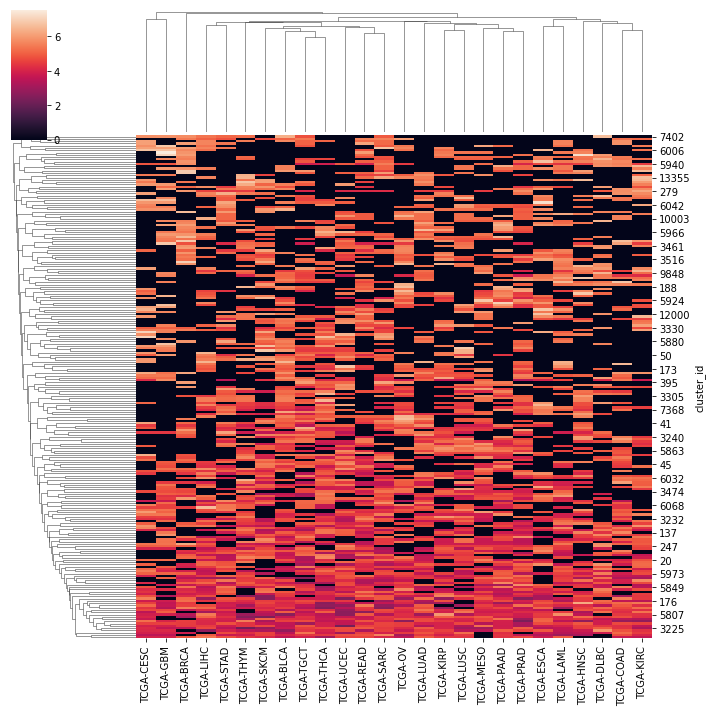

In [21]:
sns.clustermap(cluster_freqs_advanced_log)

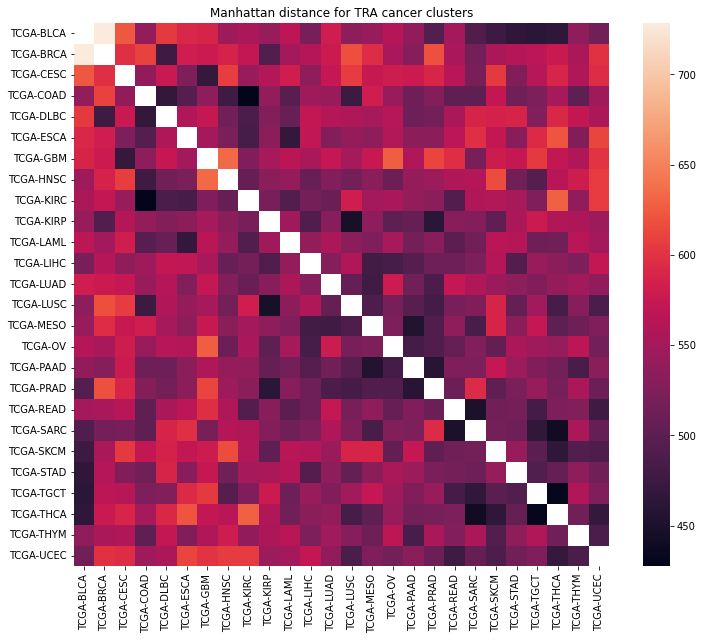

In [22]:
import scipy as scp

res_matrix = {}

for pat in cluster_freqs_advanced_log.columns:
    res_matrix[pat] = {}
    for pat1 in cluster_freqs_advanced_log.columns:
        res_matrix[pat][pat1] = scp.spatial.distance.cityblock(
            cluster_freqs_advanced_log[pat], cluster_freqs_advanced_log[pat1]
        )
plt.figure(figsize=(12, 10))
sns.heatmap(pd.DataFrame(res_matrix).applymap(lambda x: np.nan if x == 0 else x))
plt.title("Manhattan distance for TRA cancer clusters")
plt.savefig("./pics/Manhattan_TRA.jpg")

### Jensen-Shannon Divergence (JS divergence)

Jensen-Shannon Divergence is a method to measure the difference between two datasets or distributions. It essentially "averages" information from both sets and quantifies their dissimilarity.

**Key properties:**
- Values range between 0 and 1
  - Values closer to 0 indicate similar distributions
  - Values closer to 1 indicate more divergent distributions

**Our applications:**
- Measuring repertoire similarity in immunology
- Evaluating clustering quality

In [24]:
import scipy as scp

jensenshannon_dict_dif = {}
for pat in pats:
    jensenshannon_dict_dif[pat] = {}
    for pat1 in pats:
        jensenshannon_dict_dif[pat][pat1] = scp.spatial.distance.jensenshannon(
            (cluster_counts / cluster_counts.sum())[pat],
            (cluster_counts / cluster_counts.sum())[pat1],
        )

/home/dryazancev/.local/lib/python3.8/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/dryazancev/.local/lib/python3.8/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


<Figure size 864x720 with 0 Axes>

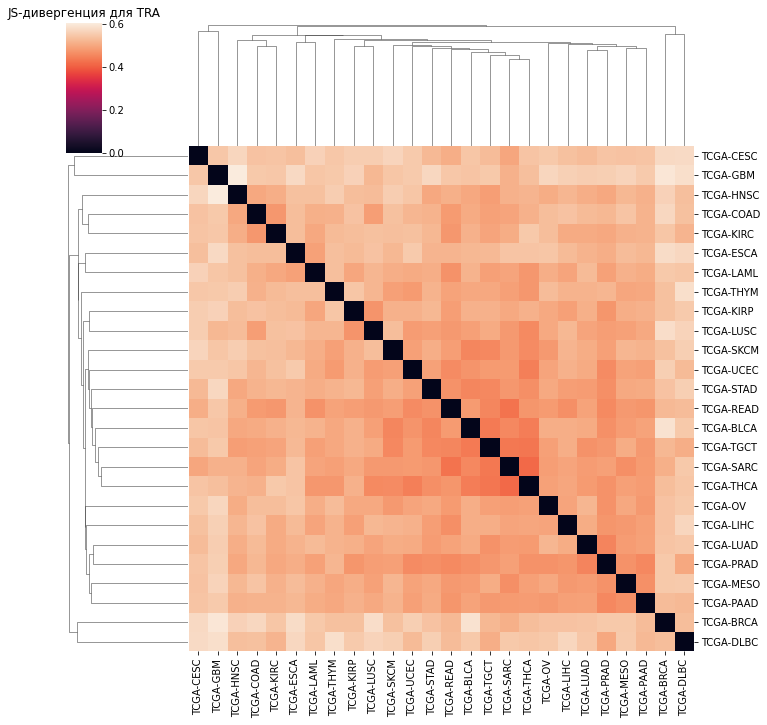

In [25]:
plt.figure(figsize=(12, 10))
a = pd.DataFrame(jensenshannon_dict_dif).applymap(lambda x: np.nan if x == 0 else x)
a = a.fillna(0)
sns.clustermap(a)
plt.title("JS-дивергенция для TRA")
plt.savefig("./pics/JS-divergention_TRA.jpg")

In [28]:
a = pd.DataFrame(jensenshannon_dict_dif).applymap(lambda x: np.nan if x == 0 else x)
a = a.fillna(0)
# a=a.drop(columns = ['TCGA-UCS', 'TCGA-KICH', 'TCGA-ACC', 'TCGA-UVM'], index=['TCGA-UCS', 'TCGA-KICH', 'TCGA-ACC', 'TCGA-UVM'])

/home/dryazancev/.local/lib/python3.8/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/dryazancev/.local/lib/python3.8/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


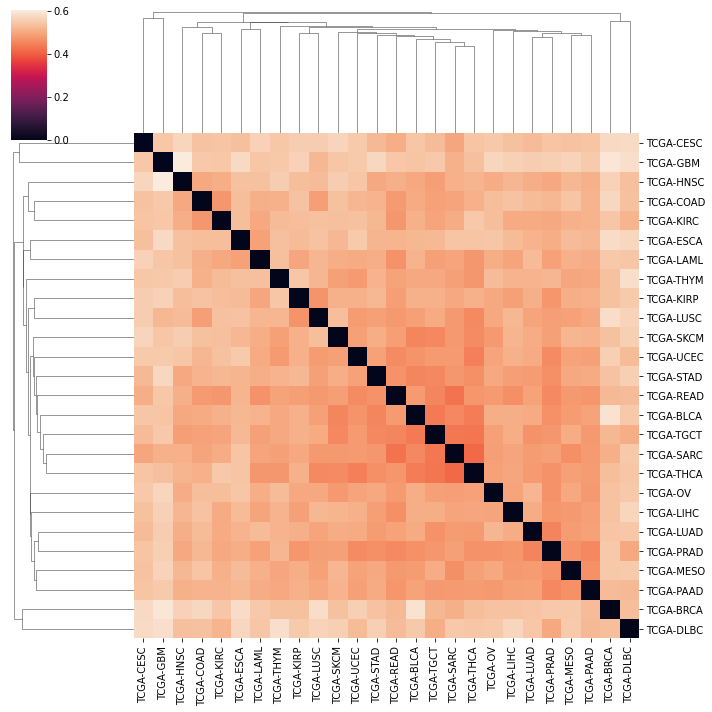

In [29]:
sns.clustermap(a)

Пока забудем про часть ниже

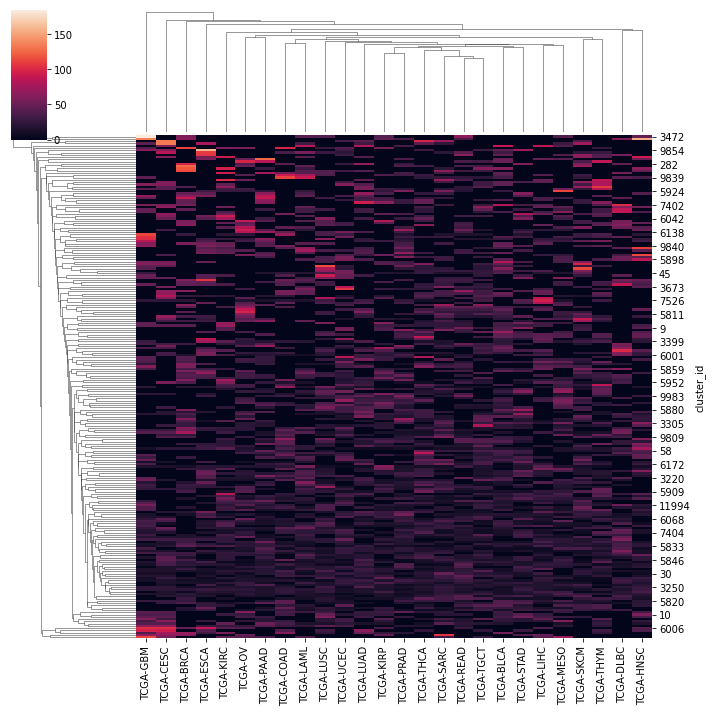

In [30]:
cluster_counts = (
    dummies_conc[["cluster_id"] + pats]
    .groupby("cluster_id")
    .apply(sum)
    .drop("cluster_id", axis=1)
)
cluster_counts.insert(0, "total_count", cluster_counts.sum(axis=1))

cluster_freqs = cluster_counts.apply(lambda x: x / cluster_counts.total_count).drop(
    "total_count", axis=1
)

cluster_freqs_advanced = (
    cluster_freqs * 10**5 / cluster_counts[cluster_freqs.columns].sum()
)
sns.clustermap(cluster_freqs_advanced)

# Analyze big clusters

In [31]:
to_plot_conc.head(2)

,cluster_size,cdr3,cluster_id,file.name,sample,locus,v_call,j_call,c_call,junction,...,tissue_or_organ_of_origin,days_to_birth,progression_or_recurrence,prior_malignancy,site_of_resection_or_biopsy,days_to_last_follow_up,therapeutic_agents,treatment_intent_type,treatment_or_therapy,priority
0,1,CNAGAAGNMLTF,5802,/projects/tcga/data/TCGA-GC-A3I6.1.clonotypes....,TCGA-GC-A3I6,TRA,TRAV26-2,TRAJ39,TRAC,TGCAACGCGGGGGCTGCAGGCAACATGCTCACCTTT,...,C67.9,-16504.0,not reported,not reported,C67.9,68.0,--,--,--,2
1,1,CAVVRASGTYKYIF,0,/projects/tcga/data/TCGA-G2-A2EC.1.clonotypes....,TCGA-G2-A2EC,TRA,TRAV36DV7,TRAJ40,TRAC,TGTGCTGTGGTAAGGGCCTCAGGAACCTACAAATACATCTTT,...,C67.9,-21215.0,not reported,not reported,C67.9,679.0,--,--,--,2


Analyzing project_id representation in large clusters

In [28]:
to_plot_conc[to_plot_conc["cluster_id"] == 15240].head(2)

,cluster_size,cdr3,cluster_id,file.name,sample,locus,v_call,j_call,c_call,junction,...,tissue_or_organ_of_origin,days_to_birth,progression_or_recurrence,prior_malignancy,site_of_resection_or_biopsy,days_to_last_follow_up,therapeutic_agents,treatment_intent_type,treatment_or_therapy,priority
3,3047,CALVKAAGNKLTF,15240,/projects/tcga/data/TCGA-02-0055.1.clonotypes....,TCGA-02-0055,TRA,TRAV9-2,TRAJ17,NaN,TGTGCTCTGGTCAAAGCTGCAGGCAACAAGCTAACTTTT,...,C71.9,-22798.0,not reported,not reported,C71.9,76.0,--,--,--,0
568,3047,CAVKRNAGNMLTF,15240,/projects/tcga/data/TCGA-05-4382.1.clonotypes....,TCGA-05-4382,TRA,TRAV8-1,TRAJ39,NaN,TGTGCCGTGAAGCGTAATGCAGGCAACATGCTCACCTTT,...,C34.1,-24868.0,not reported,not reported,C34.1,607.0,--,--,--,1


In [26]:
top_clusters_list = (
    to_plot_conc[["cluster_id", "cluster_size"]]
    .drop_duplicates("cluster_id")
    .sort_values("cluster_size", ascending=False)
    .head(5)
)["cluster_id"].tolist()
top_clusters_list

[5807, 3225, 5823, 9794, 5913]

/scratch/ipykernel_2313215/388352871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['TCGA_project'] = top_df['TCGA_project'].str.replace('TCGA-', '')


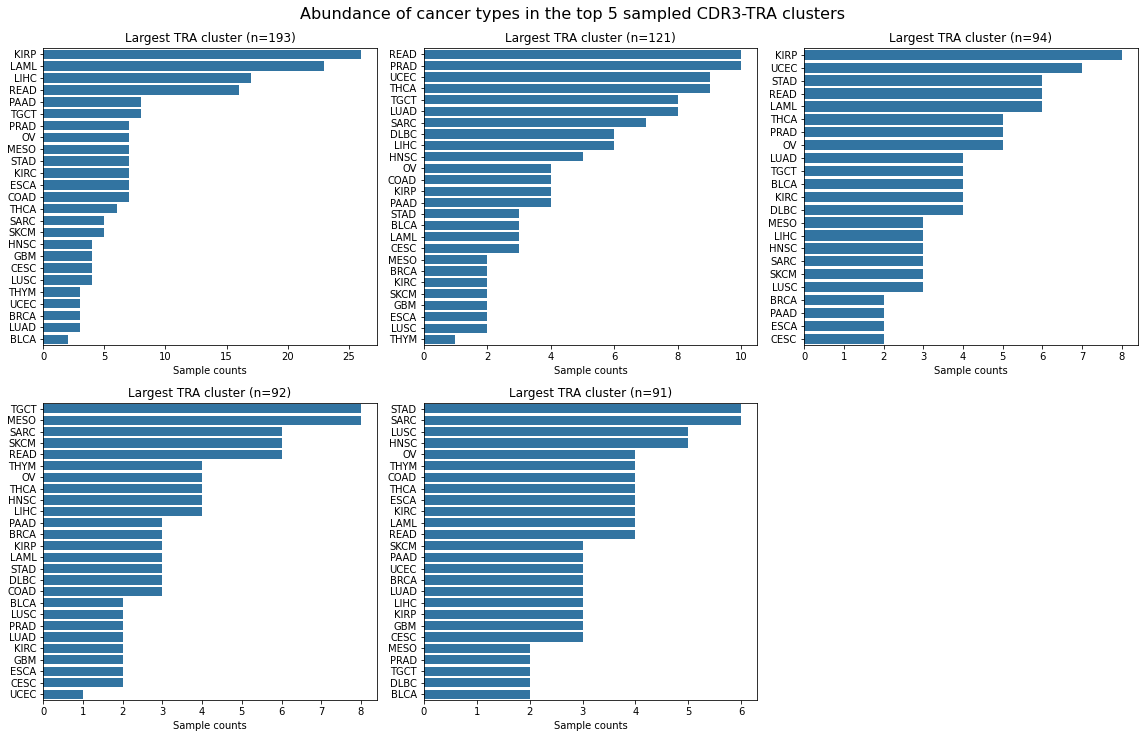

In [43]:
top_df = to_plot_conc[to_plot_conc["cluster_id"].isin(top_clusters_list)]
top_df["TCGA_project"] = top_df["TCGA_project"].str.replace("TCGA-", "")

plt.figure(figsize=(16, 10))
for i, cluster_id in enumerate(top_clusters_list):
    plt.subplot(2, 3, i + 1)
    subset = top_df[top_df["cluster_id"] == cluster_id]
    project_counts = subset["TCGA_project"].value_counts()

    sns.barplot(x=project_counts.values, y=project_counts.index)
    # plt.title(f'TRA: cluster {cluster_id} (n={project_counts.sum()})')
    plt.title(f"Largest TRA cluster (n={project_counts.sum()})")
    plt.xlabel("Sample counts")
    plt.ylabel("")

plt.tight_layout()
plt.suptitle(
    "Abundance of cancer types in the top 5 sampled CDR3-TRA clusters",
    fontsize=16,
    y=1.02,
)
plt.savefig("pics/top_clusters_TRA.png")
plt.show()

top 1 cluster with mait

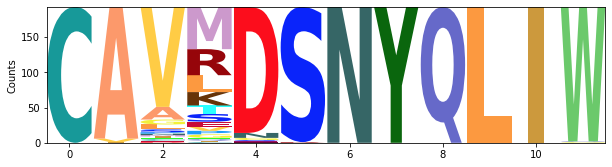

In [40]:
cdr3s = to_plot_conc[to_plot_conc.cluster_id == 5807].cdr3
mat_df = logomaker.alignment_to_matrix(cdr3s)
logomaker.Logo(mat_df, color_scheme="skylign_protein", ax=None)
plt.ylabel("Counts")
plt.savefig("pics/logo_top_cluster_TRA_mait.jpg")
plt.show()

Get logo for top clusters

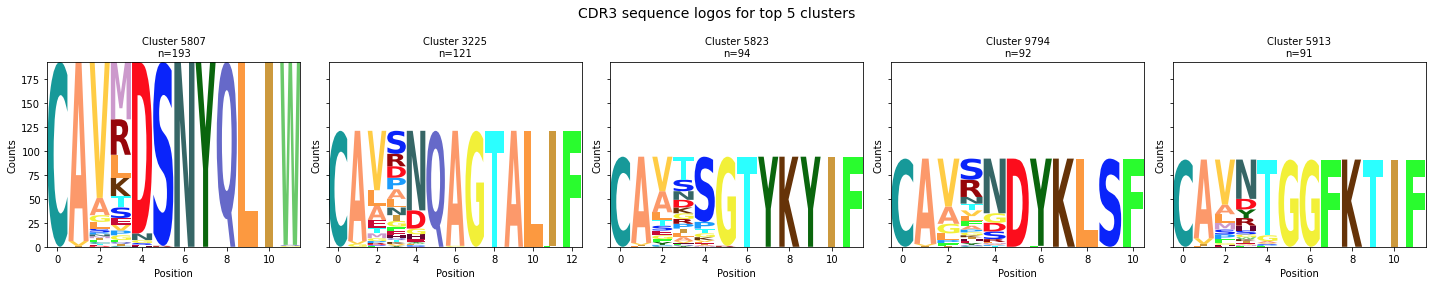

In [28]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for i, cluster_id in enumerate(top_clusters_list):
    cdr3s = to_plot_conc[to_plot_conc.cluster_id == cluster_id].cdr3
    mat_df = logomaker.alignment_to_matrix(cdr3s)

    logomaker.Logo(mat_df, color_scheme="skylign_protein", ax=axes[i])
    axes[i].set_title(f"Cluster {cluster_id}\nn={len(cdr3s)}", fontsize=10)
    axes[i].set_ylabel("Counts")
    axes[i].set_xlabel("Position")

plt.suptitle("CDR3 sequence logos for top 5 clusters", fontsize=14)
plt.tight_layout()
plt.show()

## Checking for MAIT cells presence in large clusters

In [29]:
# try 1
print(top_clusters_list)
cluster_df = top_df[top_df["cluster_id"] == top_clusters_list[0]]
mait_cells = cluster_df.loc[
    (cluster_df["j_call"].isin(["TRAJ12", "TRAJ20", "TRAJ33"]))
    & (cluster_df["v_call"] == "TRAV1-2")
    & (cluster_df["cdr3aa"].apply(lambda x: len(x) == 12))
    # cluster_df['cdr3aa'] == 'CAVRDSNYQLIW'
]
mait_cells

[5807, 3225, 5823, 9794, 5913]


,cluster_size,cdr3,cluster_id,file.name,sample,locus,v_call,j_call,c_call,junction,...,tissue_or_organ_of_origin,days_to_birth,progression_or_recurrence,prior_malignancy,site_of_resection_or_biopsy,days_to_last_follow_up,therapeutic_agents,treatment_intent_type,treatment_or_therapy,priority
1630,193,CAVTDSNYQLIW,5807,/projects/tcga/data/TCGA-LL-A5YP.1.clonotypes....,TCGA-LL-A5YP,TRA,TRAV1-2,TRAJ33,TRAC,TGTGCTGTGACGGATAGCAACTATCAGTTAATCTGG,...,C50.9,-18041.0,not reported,not reported,C50.9,450.0,--,--,--,4
1835,193,CAVVDSNYQLIW,5807,/projects/tcga/data/TCGA-DS-A0VL.1.clonotypes....,TCGA-DS-A0VL,TRA,TRAV1-2,TRAJ33,NaN,TGTGCTGTGGTGGATAGCAACTATCAGTTAATCTGG,...,C53.9,-9186.0,not reported,not reported,C53.9,81.0,--,--,--,4
2765,193,CAVMDSNYQLIW,5807,/projects/tcga/data/TCGA-A6-6648.1.clonotypes....,TCGA-A6-6648,TRA,TRAV1-2,TRAJ33,NaN,TGTGCTGTTATGGATAGCAACTATCAGTTAATCTGG,...,C18.6,-20641.0,not reported,not reported,C18.6,766.0,--,--,--,4
3333,193,CAVMDSNYQLIW,5807,/projects/tcga/data/TCGA-CM-6162.1.clonotypes....,TCGA-CM-6162,TRA,TRAV1-2,TRAJ33,NaN,TGTGCTGTGATGGATAGCAACTATCAGTTAATCTGG,...,C18.2,-17624.0,not reported,not reported,C18.2,365.0,--,--,--,4
3335,193,CAPMDSNYQLIW,5807,/projects/tcga/data/TCGA-CA-5797.1.clonotypes....,TCGA-CA-5797,TRA,TRAV1-2,TRAJ33,TRAC,TGTGCCCCAATGGATAGCAACTATCAGTTAATCTGG,...,C18.9,-20662.0,not reported,not reported,C18.9,383.0,--,--,--,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21254,193,CAVSDSNYQLIW,5807,/projects/tcga/data/TCGA-EM-A3AR.1.clonotypes....,TCGA-EM-A3AR,TRA,TRAV1-2,TRAJ33,TRAC,TGTGCTGTGAGTGATAGCAACTATCAGTTAATCTGG,...,C73.9,-15313.0,not reported,not reported,C73.9,1133.0,--,--,--,4
21515,193,CAVKDSNYQLIW,5807,/projects/tcga/data/TCGA-EL-A3H3.1.clonotypes....,TCGA-EL-A3H3,TRA,TRAV1-2,TRAJ33,NaN,TGTGCTGTTAAGGATAGCAACTATCAGTTAATCTGG,...,C73.9,-7000.0,not reported,not reported,C73.9,1319.0,--,--,--,4
21768,193,CVVMDSNYQLIW,5807,/projects/tcga/data/TCGA-EL-A3GZ.2.clonotypes....,TCGA-EL-A3GZ,TRA,TRAV1-2,TRAJ33,TRAC,TGTGTTGTTATGGATAGCAACTATCAGTTAATCTGG,...,C73.9,-12665.0,not reported,not reported,C73.9,4258.0,--,--,--,4
22876,193,CAVLDSNYQLIW,5807,/projects/tcga/data/TCGA-SJ-A6ZI.1.clonotypes....,TCGA-SJ-A6ZI,TRA,TRAV1-2,TRAJ33,TRAC,TGTGCTGTTTTGGATAGCAACTATCAGTTAATCTGG,...,C54.1,-23653.0,not reported,not reported,C54.1,631.0,--,--,--,4


In [30]:
print(cluster_df.shape, mait_cells.shape)

(193, 42) (139, 42)


In [31]:
# all 5 top clusters
for cluster in top_clusters_list:
    a = top_df[top_df["cluster_id"] == cluster]
    mait_cells = a.loc[
        (a["j_call"].isin(["TRAJ12", "TRAJ20", "TRAJ33"]))
        & (a["v_call"] == "TRAV1-2")
        & a["cdr3aa"].apply(lambda x: len(x) == 12)
    ]

    print(
        f"N MAIT cells in cluster {cluster} with size {a.shape[0]}: {mait_cells.shape[0]}"
    )
    print(
        f"MAIT abundance in cluster {cluster} is: {mait_cells.shape[0]/a.shape[0]*100:.0f}%"
    )
    print()

N MAIT cells in cluster 5807 with size 193: 139
MAIT abundance in cluster 5807 is: 72%

N MAIT cells in cluster 3225 with size 121: 0
MAIT abundance in cluster 3225 is: 0%

N MAIT cells in cluster 5823 with size 94: 0
MAIT abundance in cluster 5823 is: 0%

N MAIT cells in cluster 9794 with size 92: 0
MAIT abundance in cluster 9794 is: 0%

N MAIT cells in cluster 5913 with size 91: 0
MAIT abundance in cluster 5913 is: 0%



**Findings:**
- The top cluster shows significant MAIT cell enrichment  
- These cells are overrepresented in specific cancers:  
  - **KIRP** (Kidney Renal Papillary Cell Carcinoma)  
  - **LAML** (Acute Myeloid Leukemia)  

**Interpretation:**
- Suggests potential MAIT cell involvement in these cancer types  
- May indicate tissue-specific immune responses  

# Are there large clusters populated by only one cancer type?

**Goal:**  
Identify clusters where all or nearly all (>80%) CDR3 sequences are associated with a single cancer type.

**Method:**
1. Filter out small clusters (using empirical cutoff of 6)
2. Examine remaining clusters for cancer-type specificity:
   - Target: Clusters with >80% CDR3s from one cancer
   - Compare with previous small-cluster distribution analysis

**Technical Notes:**
- Builds on prior cluster size distribution observations
- Cutoff of 6 was determined empirically

In [32]:
large_clusters = to_plot_conc[to_plot_conc.cluster_size >= 6]
print(large_clusters.shape)
large_clusters.head(2)

(7169, 42)


,cluster_size,cdr3,cluster_id,file.name,sample,locus,v_call,j_call,c_call,junction,...,tissue_or_organ_of_origin,days_to_birth,progression_or_recurrence,prior_malignancy,site_of_resection_or_biopsy,days_to_last_follow_up,therapeutic_agents,treatment_intent_type,treatment_or_therapy,priority
3,30,CAVPGGGADGLTF,3220,/projects/tcga/data/TCGA-ZF-AA5H.1.clonotypes....,TCGA-ZF-AA5H,TRA,TRAV2,TRAJ45,TRAC,TGTGCTGTGCCAGGAGGAGGTGCTGACGGACTCACCTTT,...,C67.9,-22122.0,not reported,not reported,C67.9,897.0,--,--,--,2
5,24,CAVSALTGGGNKLTF,7362,/projects/tcga/data/TCGA-E7-A97P.1.clonotypes....,TCGA-E7-A97P,TRA,TRAV12-2,TRAJ10,TRAC,TGTGCCGTGAGTGCACTCACGGGAGGAGGAAACAAACTCACCTTT,...,C67.9,-26956.0,not reported,not reported,C67.9,13.0,--,--,--,2


No clusters with single unique cancer :(

In [33]:
large_clusters.groupby("cluster_id").filter(
    lambda grp: grp["TCGA_project"].nunique() == 1
)

,cluster_size,cdr3,cluster_id,file.name,sample,locus,v_call,j_call,c_call,junction,...,tissue_or_organ_of_origin,days_to_birth,progression_or_recurrence,prior_malignancy,site_of_resection_or_biopsy,days_to_last_follow_up,therapeutic_agents,treatment_intent_type,treatment_or_therapy,priority


It's still too small a cluster. There are no clusters with 2 unique cancers.

In [34]:
filtered = large_clusters.groupby("cluster_id").filter(
    lambda grp: grp["TCGA_project"].nunique() == 3
)
print(filtered.shape)
print(filtered.TCGA_project.value_counts())
filtered

(6, 42)
TCGA_project
TCGA-CESC    3
TCGA-READ    2
TCGA-STAD    1
Name: count, dtype: int64


,cluster_size,cdr3,cluster_id,file.name,sample,locus,v_call,j_call,c_call,junction,...,tissue_or_organ_of_origin,days_to_birth,progression_or_recurrence,prior_malignancy,site_of_resection_or_biopsy,days_to_last_follow_up,therapeutic_agents,treatment_intent_type,treatment_or_therapy,priority
1929,6,CAVDKRGSQGNLIF,433,/projects/tcga/data/TCGA-LP-A5U2.1.clonotypes....,TCGA-LP-A5U2,TRA,TRAV39,TRAJ42,TRAC,TGTGCCGTGGACAAAAGGGGAAGCCAAGGAAATCTCATCTTT,...,C53.9,-11049.0,not reported,not reported,C53.9,9.0,--,--,--,4
2110,6,CAVRDRGSQGNLIF,433,/projects/tcga/data/TCGA-RA-A741.1.clonotypes....,TCGA-RA-A741,TRA,TRAV1-2,TRAJ42,NaN,TGTGCTGTGAGAGATCGAGGAAGCCAAGGAAATCTCATCTTT,...,C53.9,-12607.0,not reported,not reported,C53.9,444.0,--,--,--,4
2112,6,CAVDDRGSQGNLIF,433,/projects/tcga/data/TCGA-LP-A5U2.1.clonotypes....,TCGA-LP-A5U2,TRA,TRAV39,TRAJ42,TRAC,TGTGCCGTGGACGATAGAGGAAGCCAAGGAAATCTCATCTTT,...,C53.9,-11049.0,not reported,not reported,C53.9,9.0,--,--,--,4
16868,6,CAVRDRGSQGNLIF,433,/projects/tcga/data/TCGA-CI-6624.1.clonotypes....,TCGA-CI-6624,TRA,TRAV1-2,TRAJ42,TRAC,TGTGCTGTGAGAGATCGAGGAAGCCAAGGAAATCTCATCTTT,...,C20.9,-19419.0,not reported,not reported,C20.9,1466.0,--,--,--,4
16933,6,CAVRYRGSQGNLIF,433,/projects/tcga/data/TCGA-AF-2690.1.clonotypes....,TCGA-AF-2690,TRA,TRAV41,TRAJ42,TRAC,TGTGCTGTCAGATACAGGGGAAGCCAAGGAAATCTCATCTTT,...,C20.9,-28119.0,not reported,not reported,C20.9,358.0,--,--,--,4
19420,6,CAVRDRGSQGNLIF,433,/projects/tcga/data/TCGA-VQ-A925.1.clonotypes....,TCGA-VQ-A925,TRA,TRAV3,TRAJ42,NaN,TGTGCTGTGAGAGACAGAGGAAGCCAAGGAAATCTCATCTTT,...,C16.3,-24230.0,not reported,not reported,C16.3,--,--,--,--,4


In [35]:
filtered["cluster_id"].unique()

array([433])

Group up

In [36]:
cancer_types_per_cluster = (
    filtered.groupby("cluster_id")["TCGA_project"].unique().reset_index()
)

cluster_sizes = filtered.groupby("cluster_id").size().reset_index(name="cluster_size")

cancer_types_with_size = cancer_types_per_cluster.merge(cluster_sizes, on="cluster_id")
cancer_types_with_size

,cluster_id,TCGA_project,cluster_size
0,433,"[TCGA-CESC, TCGA-READ, TCGA-STAD]",6


In [38]:
cluster_cancer_counts = (
    large_clusters.groupby(["cluster_id", "TCGA_project"])
    .size()
    .reset_index(name="count")
)
cluster_cancer_counts

,cluster_id,TCGA_project,count
0,9,TCGA-BLCA,1
1,9,TCGA-HNSC,1
2,9,TCGA-KIRC,1
3,9,TCGA-KIRP,1
4,9,TCGA-READ,2
...,...,...,...
4343,13355,TCGA-LUAD,1
4344,13355,TCGA-OV,1
4345,13355,TCGA-READ,1
4346,13355,TCGA-SARC,2


Now count in percent 

In [39]:
large_clusters["max_prop"] = large_clusters.groupby("cluster_id")[
    "TCGA_project"
].transform(lambda x: x.value_counts(normalize=True).iloc[0])
filtered_70 = large_clusters[large_clusters["max_prop"] >= 0.5].copy()

/scratch/ipykernel_2431954/1083320085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_clusters['max_prop'] = (


What is the distribution of % of cancer in the cluster

<Axes: >

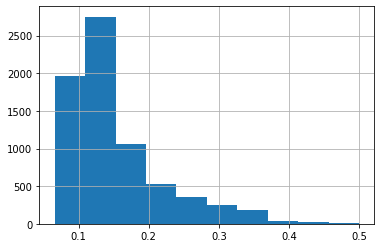

In [40]:
large_clusters.max_prop.hist()

In [41]:
clusters_70 = filtered_70["cluster_id"].unique()
print("clusters with >50% one cancer abundance: ", list(clusters_70))

clusters with >50% one cancer abundance:  [9836, 433]


In [42]:
for n_clust in clusters_70:
    print(
        "N cluster:",
        n_clust,
        "size:",
        filtered_70[filtered_70["cluster_id"] == n_clust]["cluster_size"].unique(),
    )
    print(
        filtered_70[filtered_70["cluster_id"] == n_clust]["TCGA_project"].value_counts()
    )
    print()

N cluster: 9836 size: [6]
TCGA_project
TCGA-LUAD    3
TCGA-BLCA    1
TCGA-LAML    1
TCGA-PAAD    1
Name: count, dtype: int64

N cluster: 433 size: [6]
TCGA_project
TCGA-CESC    3
TCGA-READ    2
TCGA-STAD    1
Name: count, dtype: int64



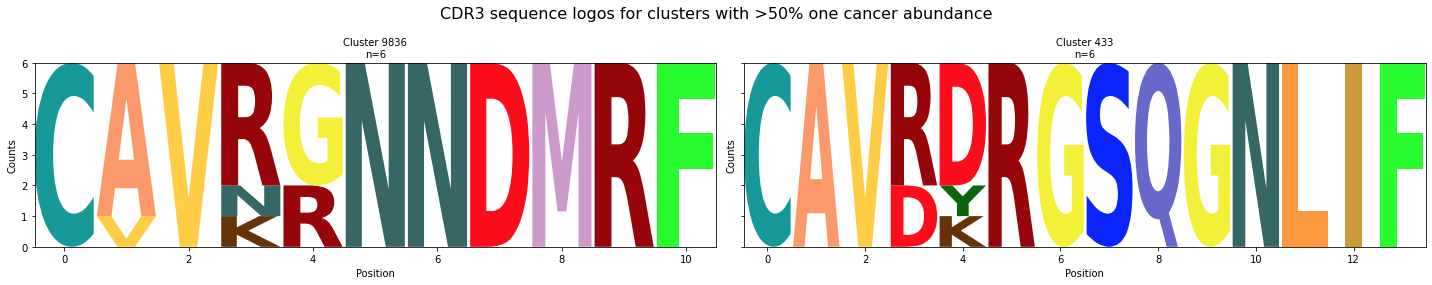

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharey=True)

for i, cluster_id in enumerate(clusters_70):
    cdr3s = filtered_70[filtered_70.cluster_id == cluster_id].cdr3
    mat_df = logomaker.alignment_to_matrix(cdr3s)

    logomaker.Logo(mat_df, color_scheme="skylign_protein", ax=axes[i])
    axes[i].set_title(f"Cluster {cluster_id}\nn={len(cdr3s)}", fontsize=10)
    axes[i].set_ylabel("Counts")
    axes[i].set_xlabel("Position")

plt.suptitle(
    "CDR3 sequence logos for clusters with >50% one cancer abundance", fontsize=16
)
plt.tight_layout()
plt.show()

In [108]:
filtered_70[filtered_70["cluster_id"] == 9836]

,cluster_size,cdr3,cluster_id,file.name,sample,locus,v_call,j_call,c_call,junction,...,days_to_birth,progression_or_recurrence,prior_malignancy,site_of_resection_or_biopsy,days_to_last_follow_up,therapeutic_agents,treatment_intent_type,treatment_or_therapy,priority,max_prop
553,6,CAVKGNNDMRF,9836,/projects/tcga/data/TCGA-FD-A5C0.1.clonotypes....,TCGA-FD-A5C0,TRA,TRAV21,TRAJ43,NaN,TGTGCTGTGAAGGGAAACAATGACATGCGCTTT,...,-22500.0,not reported,not reported,C67.4,407.0,--,--,--,2,0.5
9606,6,CAVNGNNDMRF,9836,/projects/tcga/data/TCGA-AB-2899.1.clonotypes....,TCGA-AB-2899,TRA,TRAV8-4,TRAJ43,NaN,TGTGCTGTGAACGGAAACAATGACATGCGCTTT,...,-27787.0,not reported,not reported,not reported,--,--,--,--,3,0.5
10946,6,CAVRGNNDMRF,9836,/projects/tcga/data/TCGA-75-5147.1.clonotypes....,TCGA-75-5147,TRA,TRAV39,TRAJ43,TRAC,TGTGCCGTGAGGGGTAACAATGACATGCGCTTT,...,--,not reported,not reported,C34.1,1333.0,--,--,--,1,0.5
11185,6,CAVRRNNDMRF,9836,/projects/tcga/data/TCGA-86-A4P8.1.clonotypes....,TCGA-86-A4P8,TRA,TRAV1-2,TRAJ43,NaN,TGTGCTGTGAGAAGGAACAATGACATGCGCTTT,...,-21738.0,not reported,not reported,C34.3,805.0,--,--,--,1,0.5
11579,6,CVVRRNNDMRF,9836,/projects/tcga/data/TCGA-55-7573.1.clonotypes....,TCGA-55-7573,TRA,TRAV10,TRAJ43,NaN,TGTGTGGTGCGTCGTAACAATGACATGCGCTTT,...,-26302.0,not reported,not reported,C34.1,487.0,--,--,--,1,0.5
15136,6,CAVRGNNDMRF,9836,/projects/tcga/data/TCGA-HZ-8637.1.clonotypes....,TCGA-HZ-8637,TRA,TRAV3,TRAJ43,TRAC,TGTGCTGTGAGAGGTAACAATGACATGCGCTTT,...,-27929.0,not reported,not reported,C25.0,0.0,--,--,--,4,0.5


# Fisher test

Let's use the Fisher test to see if the cluster is associated with cancer.

| | **In this cluster** | **Not in this cluster** |
| --------------- | ------------------- | ---------------------- |
| **This cancer** | a | b | | |
| **Other cancer** | c | d |


In [109]:
%%time
results = []

clusters = to_plot_conc["cluster_id"].unique()
projects = to_plot_conc["TCGA_project"].unique()

for cluster in clusters:
    in_cluster = to_plot_conc["cluster_id"] == cluster

    for project in projects:
        is_project = to_plot_conc["TCGA_project"] == project

        a = ((in_cluster) & (is_project)).sum()
        b = ((~in_cluster) & (is_project)).sum()
        c = ((in_cluster) & (~is_project)).sum()
        d = ((~in_cluster) & (~is_project)).sum()

        if a + b + c + d == 0:
            continue

        table = [[a, b], [c, d]]
        oddsratio, p_value = fisher_exact(table, alternative="greater")

        results.append(
            {
                "cluster_id": cluster,
                "project": project,
                "a": a,
                "b": b,
                "c": c,
                "d": d,
                "oddsratio": oddsratio,
                "p_value": p_value,
            }
        )

assoc_df = pd.DataFrame(results).sort_values("p_value")

In [113]:
assoc_df

,cluster_id,project,a,b,c,d,oddsratio,p_value
685,5807,TCGA-KIRP,26,877,167,22526,3.998908,2.589124e-08
686,5807,TCGA-LAML,23,873,170,22530,3.491611,1.292915e-06
13935,5879,TCGA-UCEC,5,885,11,22695,11.656394,2.329721e-04
97933,10988,TCGA-PRAD,3,924,1,22668,73.597403,2.346847e-04
14452,5886,TCGA-TGCT,6,916,18,22656,8.244541,2.573878e-04
...,...,...,...,...,...,...,...,...
123721,4235,TCGA-LUSC,0,903,1,22692,0.000000,1.000000e+00
123720,4235,TCGA-LUAD,0,913,1,22682,0.000000,1.000000e+00
123719,4235,TCGA-LIHC,0,903,1,22692,0.000000,1.000000e+00
123737,6420,TCGA-COAD,0,931,2,22663,0.000000,1.000000e+00


<Axes: >

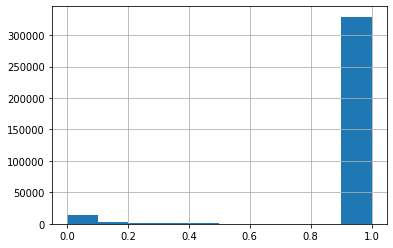

In [112]:
assoc_df.p_value.hist()